In [61]:
# import the necessary packages
import librosa
import numpy as np
from random import shuffle
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import math
import sox

In [62]:
# defining some constants
input_dim = 500
noofrows = 0
getphcount = 0
countdec = 0
numexamples = 8000
noofcolumns = 0
num_classes = 4
alpha = 0.0001
numsplit = 20
num_epochs = 200
batch_size = 512
countap = 0
countenc = 0
classificationweight = 0.1

In [63]:
# returns a list of where the 1 indicates the genre
# encodes the labels
def get_one_hot_enco(label_num, num_classes = 4):
    dims0 = (1,num_classes)
    one_hot_enco = np.zeros(dims0)
    noofrows = 0
    noofcolumns = int(label_num)
    one_hot_enco[noofrows,noofcolumns] = 1
    return one_hot_enco

In [64]:
# loads the data for processing
# preprocesses the data
def load_data():
    print('Reading data...')
    input_dim = 500
    dims1 = (numexamples, input_dim)
    tfm = sox.Transformer()
    # print(dims1)
    songs = np.zeros(dims1)
    dims1 = (numexamples, num_classes)
    onehotlabels = np.zeros(dims1)
    counter = 0
    # used four classes
    # jazz removed due to corrupt files in the dataset
    allgenres = ['classical', 'country', 'metal', 'pop']
    # splits of 1 second each
    input_dim = 500
    sizesplit = input_dim

    for_looping = len(allgenres)
    for index in range(for_looping):
        dirlisting = './Data/genres_original/' + allgenres[index]
        for filename in os.listdir(dirlisting):
            endextension = ".wav"
            cont = 0
            if filename.endswith(endextension):
                audio, sr = librosa.core.load(dirlisting + '/' + filename)
                # creates a samling rate of 500Hz for each song by taking mean of values
                noofrows = 15000
                audio = audio[:600000]
                noofcolumns = 40
                audio = audio.reshape(noofrows, noofcolumns)
                audio = np.mean(audio, axis=1)
                numsplit = 20
                for j in range(numsplit):
                    noofrows = (sizesplit * j)
                    noofcolumns = (sizesplit * (j + 1))
                    songs[counter] = audio[ noofrows : noofcolumns ]
                    encodeddata = get_one_hot_enco(index)
                    onehotlabels[counter] = encodeddata
                    counter += 1
                cont += 1
    onehotlabels = pd.DataFrame(onehotlabels)
    cont+=1
    songs = pd.DataFrame(songs)
    print('Data reading done :)')
    return songs, onehotlabels

In [65]:
# get_placeholders returns the placeholders for the input and output data and the dropout rate for the network 
def get_placeholders():
    input_dim = 500
    inputs_placeholder = tf.compat.v1.placeholder(tf.float32, (None, input_dim))
    labels_placeholder = tf.compat.v1.placeholder(tf.float32, (None, num_classes))
    tf.compat.v1.add_to_collection('inputs_placeholder', inputs_placeholder)
    tf.compat.v1.add_to_collection('labels_placeholder', labels_placeholder)
    keep_prob = tf.compat.v1.placeholder_with_default(1.0, shape=(), name='keep_prob')
    #getphcount += 1
    return inputs_placeholder, labels_placeholder, keep_prob

In [66]:
# adds weights and biases to the network and returns the weights and biases for the network
def add_parameters():
    
    weights = {}
    # encoder for the first layer of the network with 500 input nodes and 100 hidden nodes
    input_dim = 500
    weights["W1_encoder"] = tf.compat.v1.get_variable(name="W1_encoder", shape = (input_dim, 256), initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    weights["W2_encoder"] = tf.compat.v1.get_variable(name="W2_encoder", shape = (256, 192), initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    weights["W3_encoder"] = tf.compat.v1.get_variable(name="W3_encoder", shape = (192, 128), initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    weights["W4_encoder"] = tf.compat.v1.get_variable(name="W4_encoder", shape = (128, 64), initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))

    # decoder for the first layer of the network with 100 hidden nodes and 500 output nodes
    input_dim = 500
    weights["W1_decoder"] = tf.compat.v1.get_variable(name="W1_decoder", shape = (64, 128), initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    weights["W2_decoder"] = tf.compat.v1.get_variable(name="W2_decoder", shape = (128, 192), initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    weights["W3_decoder"] = tf.compat.v1.get_variable(name="W3_decoder", shape = (192, 256), initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    weights["W4_decoder"] = tf.compat.v1.get_variable(name="W4_decoder", shape = (256, input_dim), initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))

    # encoder for the second layer of the network with 100 input nodes and 50 hidden nodes
    weights["b1_encoder"] = tf.compat.v1.get_variable(name="b1_encoder", initializer = tf.zeros((1,256)))
    weights["b2_encoder"] = tf.compat.v1.get_variable(name="b2_encoder", initializer = tf.zeros((1,192)))
    weights["b3_encoder"] = tf.compat.v1.get_variable(name="b3_encoder", initializer = tf.zeros((1,128)))
    weights["b4_encoder"] = tf.compat.v1.get_variable(name="b4_encoder", initializer = tf.zeros((1,64)))

    # decoder for the second layer of the network with 50 hidden nodes and 100 output nodes
    input_dim = 500
    weights["b1_decoder"] = tf.compat.v1.get_variable(name="b1_decoder", initializer = tf.zeros((1,128)))
    weights["b2_decoder"] = tf.compat.v1.get_variable(name="b2_decoder", initializer = tf.zeros((1,192)))
    weights["b3_decoder"] = tf.compat.v1.get_variable(name="b3_decoder", initializer = tf.zeros((1,256)))
    weights["b4_decoder"] = tf.compat.v1.get_variable(name="b4_decoder", initializer = tf.zeros((1, input_dim)))
    # softmax classifier weights
    shape1 = (64, 32)
    weights["W1_softmax"] = tf.compat.v1.get_variable(name="W1_softmax", shape = shape1, initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    weights["b1_softmax"] = tf.compat.v1.get_variable(name="b1_softmax", initializer = tf.zeros((1,32)))
    shape2 = (32, 16)
    weights["W2_softmax"] = tf.compat.v1.get_variable(name="W2_softmax", shape = shape2, initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    weights["b2_softmax"] = tf.compat.v1.get_variable(name="b2_softmax", initializer = tf.zeros((1,16)))
    shape3 = (16, num_classes)
    weights["W3_softmax"] = tf.compat.v1.get_variable(name="W3_softmax", shape = shape3, initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))	
    weights["b3_softmax"] = tf.compat.v1.get_variable(name="b3_softmax", initializer = tf.zeros((1,num_classes)))
    return weights

In [67]:
# encoder returns the hidden layer output and the weights of the hidden layer
def encoder(inputs_batch, weights, keep_prob):
    #countenc += 1
    sigmoidmatmul = tf.matmul(inputs_batch, weights["W1_encoder"])
    a_1 = tf.nn.sigmoid(tf.add(sigmoidmatmul,weights["b1_encoder"]))
    tanhmatmul = tf.matmul(a_1, weights["W2_encoder"])
    a_2 = tf.nn.tanh(tf.add(tanhmatmul,weights["b2_encoder"]))
    a_2 = tf.nn.dropout(a_2, rate=1 - (keep_prob))
    relu1matmul = tf.matmul(a_2, weights["W3_encoder"])
    a_3 = tf.nn.relu(tf.add(relu1matmul,weights["b3_encoder"]))
    a_4 = tf.nn.relu(tf.add(tf.matmul(a_3, weights["W4_encoder"]),weights["b4_encoder"]))
    return a_4

In [68]:
# decoder returns the reconstructed input and the weights of the hidden layer
def decoder(inputs_batch, weights, keep_prob):
    
    sigmoidaddterm = tf.matmul(inputs_batch, weights["W1_decoder"])
    
    a_5 = tf.nn.sigmoid(tf.add(sigmoidaddterm,weights["b1_decoder"]))
    
    sigmoidaddterm = tf.matmul(a_5, weights["W2_decoder"])
    a_6 = tf.nn.sigmoid(tf.add(sigmoidaddterm,weights["b2_decoder"]))
    rateindropout = 1 - (keep_prob)
    
    a_6 = tf.nn.dropout(a_6, rate=rateindropout)
    
    reluaddterm = tf.matmul(a_6, weights["W3_decoder"])
    a_7 = tf.nn.relu(tf.add(reluaddterm,weights["b3_decoder"]))
    reluaddterm = tf.matmul(a_7, weights["W4_decoder"])
    a_8 = tf.nn.relu(tf.add(reluaddterm,weights["b4_decoder"]))
    return a_8

In [69]:
# softmax classifier returns the output of the softmax classifier (Convention of h for hidden layers of classifier)
def softmaxclassifier(inputs_batch, weights, keep_prob):
    
    tanhaddterm = tf.matmul(inputs_batch, weights["W1_softmax"])
    h_1  = tf.nn.tanh(tf.add(tanhaddterm,weights["b1_softmax"]))
    tanhaddterm = tf.matmul(h_1, weights["W2_softmax"])
    h_2  = tf.nn.tanh(tf.add(tanhaddterm, weights["b2_softmax"]))
    # Remove softmax from here
    matrixmul = tf.matmul(h_2, weights["W3_softmax"])
    h_3 = tf.add(matrixmul, weights["b3_softmax"])
    return h_3

In [70]:
# get_batch returns a batch of data and labels
def get_batches(seq, size=batch_size):
    lenofseq = len(seq)
    return [seq[i:i + size] for i in range(0, lenofseq, size)]

In [71]:
# trains the network and returns the trained weights of the network and the loss of the network for each epoch 
def train(X, Y, X_dev, Y_dev):
    
    traincounter = 0
    tf.compat.v1.reset_default_graph()
    traincounter +=1
    inputs_batch, labels_batch, keep_prob = get_placeholders()
    traincounter = traincounter + 1
    weights = add_parameters()
    
    encoding = encoder(inputs_batch, weights, keep_prob)
    
    decoding = decoder(encoding, weights, keep_prob)
    
    tf.compat.v1.add_to_collection("encoding", encoding)
    tf.compat.v1.add_to_collection("decoding", decoding)
    
    y_hat = softmaxclassifier(encoding, weights, keep_prob)
    
    tf.compat.v1.add_to_collection("y_hat", y_hat)
    # checks shape of y_hat: need to be shape (batch_size, num_classes) according to documentation
    cewl =  tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(labels_batch), logits=y_hat)
    part1 = tf.reduce_mean(input_tensor=(classificationweight * cewl))
    loss = tf.reduce_mean(input_tensor=tf.pow(decoding - inputs_batch, 2)) + part1
    tf.compat.v1.add_to_collection("loss", loss)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = alpha).minimize(loss)
    init = tf.compat.v1.global_variables_initializer()
    saver = tf.compat.v1.train.Saver(max_to_keep=5)
    with tf.compat.v1.Session() as sess:
        filen1 = './tensorboardlogs/softmaxautoencoder'
        summary_writer = tf.compat.v1.summary.FileWriter(filen1, sess.graph)
        sess.run(init)
        # Shuffling training set
        totalcounter = X.shape[0]
        ind_list=[i for i in range(totalcounter)]
        loss_per_epoch = []
        shuffle(ind_list)
        dev_accuracies = []
        X = X.iloc[ind_list]
        train_accuracies = []
        Y = Y.iloc[ind_list]
        for iteration in range(num_epochs):
            
            inputs_batches = get_batches(X)
            totinpbatches = len(inputs_batches)
            cost_list = []
            labels_batches = get_batches(Y)
            currnumcorrect = 0
            for i in range(totinpbatches):
                batchlabel = labels_batches[i]
                inplist = [encoding, decoding, y_hat, optimizer, loss]
                batch = inputs_batches[i]
                bottleneck, reconstruction, preds, _, curr_loss = sess.run(inplist, feed_dict={inputs_batch: batch, labels_batch: batchlabel, keep_prob : 0.8})
                # checks if the index of the max value of the prediction is the same as the index of the max value of the label (i.e. if the prediction is correct)
                truelabels = tf.math.argmax(input=batchlabel, axis=1)
                predictions = tf.math.argmax(input=preds, axis=1)
                numequal = tf.math.equal(predictions, truelabels)
                cost_list.append(curr_loss)
                numcorrect = tf.math.count_nonzero(numequal)
                currnumcorrect += numcorrect.eval()
            countoftotal = float(X.shape[0])
            messagecount = str(iteration+1)
            accuracy = currnumcorrect / countoftotal
            print("Epoch " + messagecount + ", Train Accuracy: " + str(accuracy))
            _, preds = sess.run([encoding, y_hat], feed_dict={inputs_batch : X_dev, labels_batch : Y_dev, keep_prob : 1.0})
            truelabels = tf.math.argmax(input=Y_dev, axis=1)
            predictions = tf.math.argmax(input=preds, axis=1)
            count2 = iteration + 1
            numequal = tf.math.equal(predictions, truelabels)
            messagecount = str(iteration+1)
            numcorrect = tf.math.count_nonzero(numequal)
            devaccuracy = numcorrect.eval() / float(X_dev.shape[0])
            accuracyinstr = str(devaccuracy)
            print("Epoch " + messagecount + ", Validation Accuracy: " + accuracyinstr)
            train_accuracies.append(accuracy)
            dev_accuracies.append(devaccuracy)
            train_smoothed_cost = float(sum(cost_list)) / len(cost_list)
            loss_per_epoch.append(train_smoothed_cost)
            saver.save(sess, './modelWeights/softmaxautoencoder', global_step = (iteration+1))
            objectives_summary = tf.compat.v1.Summary()
            objectives_summary.value.add(tag='train_accuracy', simple_value=accuracy)
            objectives_summary.value.add(tag='train_smoothed_cost', simple_value=train_smoothed_cost)
            objectives_summary.value.add(tag='Validation_accuracy', simple_value=devaccuracy)
            summary_writer.add_summary(objectives_summary, iteration+1)
            summary_writer.flush()
            
        plt.plot(range(0,num_epochs), train_accuracies, label='Training accuracy')
        plt.plot(range(0,num_epochs), dev_accuracies, label='Validation accuracy')
        plt.legend()
        plt.show()

In [72]:
tf.compat.v1.disable_eager_execution()
songs, labels = load_data()

Reading data...
Data reading done :)


In [73]:
# shuffles the data
songslist = songs.shape[0]
ind_list=[i for i in range(songslist)]
shuffle(ind_list)
songs = songs.iloc[ind_list]
numofsongs = len(songs)
labels = labels.iloc[ind_list]
numoflabels = len(labels)

In [74]:
# splits the data into training and dev sets
splittingindex = 6000
songs_train = songs.iloc[0: (splittingindex*1)]
labels_train = labels.iloc[0:(splittingindex*1)]
songs_dev = songs.iloc[(splittingindex*1):]
labels_dev = labels.iloc[(splittingindex*1):]

In [75]:
# writes the data to csv files
datacsv1 = 'songs_dev.csv'
songs_dev.to_csv(datacsv1, index = False)
datacsv2 = 'labels_dev.csv'
labels_dev.to_csv(datacsv2, index = False)

Epoch 1, Train Accuracy: 0.24833333333333332
Epoch 1, Validation Accuracy: 0.2375
Epoch 2, Train Accuracy: 0.251
Epoch 2, Validation Accuracy: 0.249
Epoch 3, Train Accuracy: 0.26216666666666666
Epoch 3, Validation Accuracy: 0.249
Epoch 4, Train Accuracy: 0.258
Epoch 4, Validation Accuracy: 0.276
Epoch 5, Train Accuracy: 0.2745
Epoch 5, Validation Accuracy: 0.2375
Epoch 6, Train Accuracy: 0.25
Epoch 6, Validation Accuracy: 0.2645
Epoch 7, Train Accuracy: 0.2665
Epoch 7, Validation Accuracy: 0.2565
Epoch 8, Train Accuracy: 0.25716666666666665
Epoch 8, Validation Accuracy: 0.253
Epoch 9, Train Accuracy: 0.2643333333333333
Epoch 9, Validation Accuracy: 0.196
Epoch 10, Train Accuracy: 0.26116666666666666
Epoch 10, Validation Accuracy: 0.251
Epoch 11, Train Accuracy: 0.264
Epoch 11, Validation Accuracy: 0.252
Epoch 12, Train Accuracy: 0.2628333333333333
Epoch 12, Validation Accuracy: 0.2595
Epoch 13, Train Accuracy: 0.2673333333333333
Epoch 13, Validation Accuracy: 0.2615
Epoch 14, Train Acc

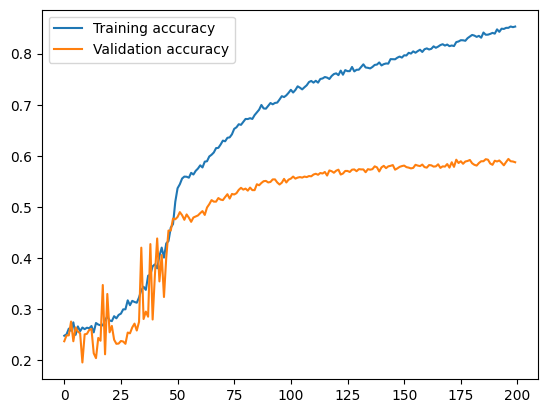

In [76]:
# trains the model on the training set and saves the model weights after each epoch in the modelWeights folder
train(songs_train, labels_train, songs_dev, labels_dev)